In [42]:
import math, re, os
import tensorflow as tf
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.7.0


# TPU or GPU detection

In [2]:
# NEW on TPU in TensorFlow 24: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.34.90.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.34.90.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


# Mount Drive to save models and figures

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Competition data access
TPUs read data directly from Google Cloud Storage (GCS). This Kaggle utility will copy the dataset to a GCS bucket co-located with the TPU. If you have multiple datasets attached to the notebook, you can pass the name of a specific dataset to the get_gcs_path function. The name of the dataset is the name of the directory it is mounted in. Use `!ls /kaggle/input/` to list attached datasets.

In [4]:
from google.colab import auth
auth.authenticate_user()

In [5]:
project_id = 'exonet-cv-proj1-data'
!gcloud config set project {project_id}

Updated property [core/project].


In [6]:
# Test to see if dataset location is correct
! gsutil ls -al gs://exonet-b0-proj1-full-data

                                 gs://exonet-b0-proj1-full-data/Fixed_Full_TFRecord_P1/
                                 gs://exonet-b0-proj1-full-data/Full_ExoNet_4C_Final_TFRecord/
                                 gs://exonet-b0-proj1-full-data/Full_ExoNet_4C_Final_TFRecord_Non_Split/
                                 gs://exonet-b0-proj1-full-data/Kaggle Data/
                                 gs://exonet-b0-proj1-full-data/P1_25_TFRecords/
                                 gs://exonet-b0-proj1-full-data/P1_25_TFRecords_1/
                                 gs://exonet-b0-proj1-full-data/P1_Full_TFRecords_1/
                                 gs://exonet-b0-proj1-full-data/Project1_Sorted_Dataset_1/
                                 gs://exonet-b0-proj1-full-data/Project1_Sorted_Dataset_25_1/
                                 gs://exonet-b0-proj1-full-data/TFR_Test1/
                                 gs://exonet-b0-proj1-full-data/TFRecord_Test_1/


In [7]:
GCS_DS_PATH = 'gs://exonet-b0-proj1-full-data'

# Configuration

In [8]:
# Load the initial image size of 256x256
# This a random crop of 224x224 will be taken from this later

IMAGE_SIZE = [256, 256] 

# set the number of epochs for the run                        
EPOCHS = 60

# set the initial learning rate
BASE_LR = 0.00001

# 8 TPU cores, so 16 will be 128
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

#To study the effect of transfer training:
FINE_TUNE_BUFFER = 50

#Change Droprate 
DROPOUT_VALUE = 0.2

# For hyperparameter optimization set to 144 
# For final run set to 'None'
SEED_NUMBER = 144 






GCS_PATH_SELECT = { # available image sizes
    256: GCS_DS_PATH + '/Full_ExoNet_4C_Final_TFRecord',
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]
print(GCS_PATH)


TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['IS', 'IS-LG', 'LG', 'LG-IS']                                                                                                                                               # 100 - 102

gs://exonet-b0-proj1-full-data/Full_ExoNet_4C_Final_TFRecord


In [9]:
print(len(TRAINING_FILENAMES))
print(len(VALIDATION_FILENAMES))
print(len(TEST_FILENAMES))

1
1
1


## Visualization utilities
data -> pixels, nothing of much interest for the machine learning practitioner in this section.

In [10]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Datasets

In [11]:
def decode_image(image_data):
    image = tf.io.decode_raw(image_data, tf.uint8)
    # image = tf.image.decode_jpeg(image_data, channels=3)
    # image = image_data
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    image = tf.image.random_crop(value=image, size=(224, 224, 3))
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['label']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    # for hyperparameter testing using random seed to shuffle the data the same to elimite this variable from results
    dataset = dataset.shuffle(count_data_items(TRAINING_FILENAMES)/10, seed=SEED_NUMBER, reshuffle_each_iteration=None)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    # for hyperparameter testing using random seed to shuffle the data the same to elimite this variable from results
    dataset = dataset.shuffle(count_data_items(VALIDATION_FILENAMES)/10, seed=SEED_NUMBER, reshuffle_each_iteration=None)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    # for hyperparameter testing using random seed to shuffle the data the same to elimite this variable from results
    dataset = dataset.shuffle(count_data_items(TEST_FILENAMES)/10, seed=SEED_NUMBER, reshuffle_each_iteration=None)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset 

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
TEST_STEPS = -(-NUM_TEST_IMAGES // BATCH_SIZE)             # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images, {} test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 484617 training images, 18949 validation images, 37908 test images


Oversampling

In [12]:
# Get labels and their countings

def get_training_dataset_raw():

    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered=False)
    return dataset


raw_training_dataset = get_training_dataset_raw()

label_counter = Counter()
for images, labels in raw_training_dataset:
    label_counter.update([labels.numpy()])

del raw_training_dataset    
    
label_counting_sorted = label_counter.most_common()

NUM_TRAINING_IMAGES = sum([x[1] for x in label_counting_sorted])
print("number of examples in the original training dataset: {}".format(NUM_TRAINING_IMAGES))

print("labels in the original training dataset, sorted by occurrence")
label_counting_sorted

number of examples in the original training dataset: 484617
labels in the original training dataset, sorted by occurrence


[(2, 416069), (0, 45134), (3, 16412), (1, 7002)]

Define the repition size for oversampling classes

In [13]:
# We want each class occur at least (approximately) `TARGET_MIN_COUNTING` times
TARGET_MIN_COUNTING = 400000

def get_num_of_repetition_for_class(class_id):
    
    counting = label_counter[class_id]
    if counting >= TARGET_MIN_COUNTING:
        return 1.0
    
    num_to_repeat = TARGET_MIN_COUNTING / counting
    
    return num_to_repeat

numbers_of_repetition_for_classes = {class_id: get_num_of_repetition_for_class(class_id) for class_id in range(4)}

print("number of repetitions for each class (if > 1)")
{k: v for k, v in sorted(numbers_of_repetition_for_classes.items(), key=lambda item: item[1], reverse=True) if v > 1}

number of repetitions for each class (if > 1)


{0: 8.862498338281561, 1: 57.12653527563553, 3: 24.372410431391664}

In [14]:
# This will be called later in `get_training_dataset_with_oversample()`

keys_tensor = tf.constant([k for k in numbers_of_repetition_for_classes])
vals_tensor = tf.constant([numbers_of_repetition_for_classes[k] for k in numbers_of_repetition_for_classes])
table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), -1)

def get_num_of_repetition_for_example(training_example):
    
    _, label = training_example
    
    num_to_repeat = table.lookup(label)
    num_to_repeat_integral = tf.cast(int(num_to_repeat), tf.float32)
    residue = num_to_repeat - num_to_repeat_integral
    
    num_to_repeat = num_to_repeat_integral + tf.cast(tf.random.uniform(shape=()) <= residue, tf.float32)
    
    return tf.cast(num_to_repeat, tf.int64)

In [15]:
def get_training_dataset_with_oversample(repeat_dataset=True, oversample=False):

    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)

    if oversample:
        dataset = dataset.flat_map(lambda image, label: tf.data.Dataset.from_tensors((image, label)).repeat(get_num_of_repetition_for_example((image, label))))

    if repeat_dataset:
        dataset = dataset.repeat() # the training dataset must repeat for several epochs
    
    dataset = dataset.shuffle(20000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    
    return dataset

# Dataset visualizations

In [16]:
# data dump
# This will take approx 1 minutes to shuffle the data

print("Loading... Please wait for data to shuffle")
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
    print("Training data label examples:", label.numpy())
    print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
    print("Validation data label examples:", label.numpy())
    print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
    print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Loading... Please wait for data to shuffle
Training data shapes:
(256, 224, 224, 3) (256,)
Training data label examples: [2 2 2 ... 2 2 2]
Validation data shapes:
(256, 224, 224, 3) (256,)
Training data label examples: [0 2 2 ... 1 2 2]
Validation data shapes:
(256, 224, 224, 3) (256,)
Training data label examples: [2 2 2 ... 2 2 2]
Validation data shapes:
(256, 224, 224, 3) (256,)
Validation data label examples: [2 2 2 ... 3 2 2]
Test data shapes:
(256, 224, 224, 3) (256,)
Validation data label examples: [2 0 2 ... 2 2 2]
Test data shapes:
(256, 224, 224, 3) (256,)
Validation data label examples: [2 2 2 ... 2 2 2]
Test data shapes:
(256, 224, 224, 3) (256,)
Test data IDs: ['2' '2' '2' ... '2' '2' '2']
(256, 224, 224, 3) (256,)
Test data IDs: ['2' '2' '2' ... '2' '2' '2']
(256, 224, 224, 3) (256,)
Test data IDs: ['2' '2' '2' ... '2' '3' '2']


In [17]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

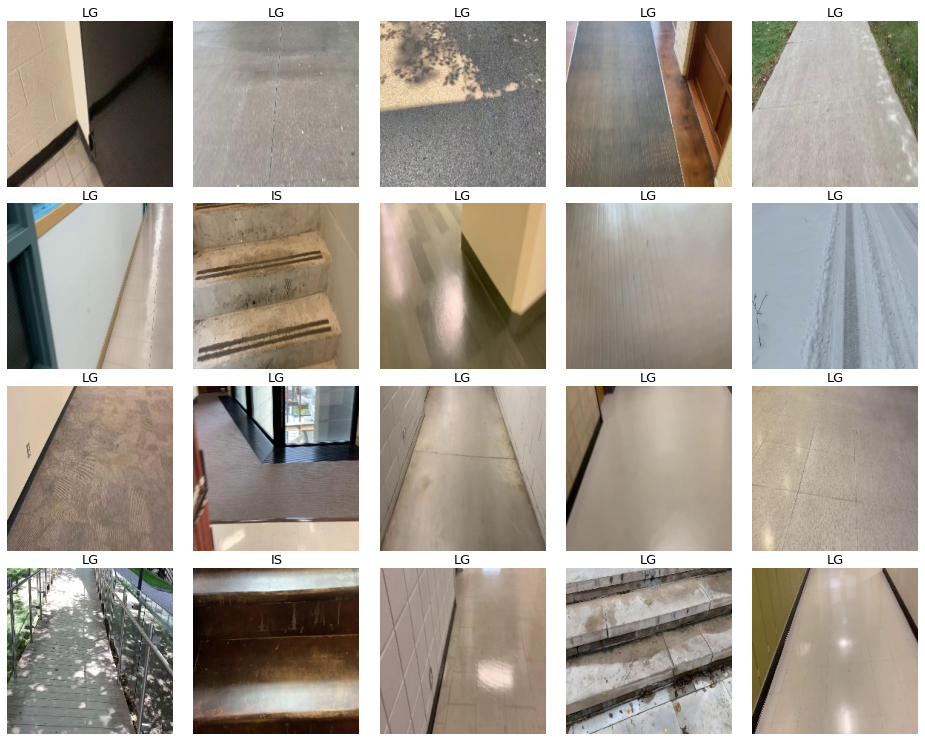

In [18]:
# run this cell again for next set of images
# This will take a little bit to load
display_batch_of_images(next(train_batch))

In [19]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

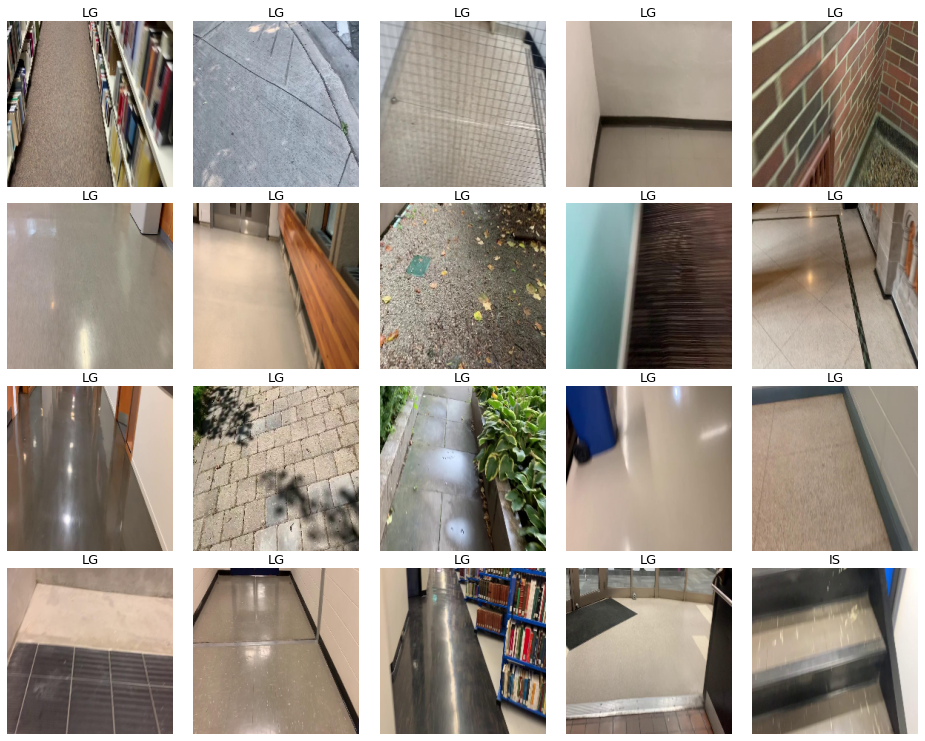

In [20]:
# run this cell again for next set of images
# This will take a little bit to load
display_batch_of_images(next(test_batch))

# Model
Not the best but it converges ...

In [21]:
import keras

def create_model():
  # for pretrained, freeze model set classes to 1000 then change the classes to 4 manually
  base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

  # Let's take a look to see how many layers are in the base model
  print("Number of layers in the base model: ", len(base_model.layers))

  # Fine-tune from this layer onwards
  fine_tune_at = FINE_TUNE_BUFFER

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  # for layer in base_model.layers:
  #   if hasattr(layer, 'kernel_regularizer'):
  #       layer.kernel_regularizer= tf.keras.regularizers.l2(0.001)

  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  # dropout_layer = tf.keras.layers.Dropout(0.2)(global_average_layer)
  prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')
  
  # define new model
  model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    tf.keras.layers.Dropout(DROPOUT_VALUE),
    prediction_layer
  ])

  return model

In [22]:
lr = tf.keras.experimental.CosineDecay(BASE_LR, STEPS_PER_EPOCH * EPOCHS) # cosine learning decay

with strategy.scope():
    #img_adjust_layer = tf.keras.layers.Lambda(lambda data: tf.keras.applications.xception.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)
    
    # img_adjust_layer = tf.keras.layers.Lambda(lambda data: tf.keras.applications.vgg16.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3])

    model = create_model()

    optimizer = tf.keras.optimizers.Adam(lr) #adam optimizer
        
model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    # predict True positives/total images
    metrics=['accuracy'],
    # NEW on TPU in TensorFlow 24: sending multiple batches to the TPU at once saves communications
    # overheads and allows the XLA compiler to unroll the loop on TPU and optimize hardware utilization.
    steps_per_execution=16
)

model.summary()
parameters = model.count_params()
print(parameters)

9420800/9406464 [==============================] - 0s 0us/step
Number of layers in the base model:  154
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 2,179,716
Non-trainable params: 83,392
___

# Training

In [23]:
print("Loading... Please wait for data to shuffle")

history = model.fit(get_training_dataset_with_oversample(repeat_dataset=True, oversample=True), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS)

Loading... Please wait for data to shuffle
Epoch 1/60
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


1893/1893 [==============================] - 183s 96ms/step - loss: 0.4554 - accuracy: 0.8269 - val_loss: 0.2441 - val_accuracy: 0.9238
Epoch 2/60
1893/1893 [==============================] - 109s 58ms/step - loss: 0.2621 - accuracy: 0.9071 - val_loss: 0.1844 - val_accuracy: 0.9437
Epoch 3/60
1893/1893 [==============================] - 112s 59ms/step - loss: 0.2232 - accuracy: 0.9234 - val_loss: 0.1809 - val_accuracy: 0.9427
Epoch 4/60
1893/1893 [==============================] - 111s 59ms/step - loss: 0.1869 - accuracy: 0.9371 - val_loss: 0.1836 - val_accuracy: 0.9445
Epoch 5/60
1893/1893 [==============================] - 112s 59ms/step - loss: 0.1453 - accuracy: 0.9521 - val_loss: 0.2253 - val_accuracy: 0.9251
Epoch 6/60
1893/1893 [==============================] - 112s 59ms/step - loss: 0.1335 - accuracy: 0.9563 - val_loss: 0.1238 - val_accuracy: 0.9633
Epoch 7/60
1893/1893 [==============================] - 112s 59ms/step - loss: 0.1258 - accuracy: 0.9589 - val_loss: 0.1241 - val

## Save Model (to google drive)

In [24]:
from datetime import date
from datetime import datetime

current_time = now = datetime.now()

model_location = f"/content/drive/MyDrive/CV_Research/TPU-Run-3/Models/Final_Model_V3"

model.save(model_location, save_format='h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


        loss  accuracy  val_loss  val_accuracy
0   0.455393  0.826868  0.244075      0.923795
1   0.262077  0.907071  0.184398      0.943744
2   0.223152  0.923385  0.180857      0.942688
3   0.186872  0.937089  0.183636      0.944483
4   0.145333  0.952097  0.225335      0.925062
5   0.133458  0.956315  0.123823      0.963323
6   0.125786  0.958893  0.124067      0.961845
7   0.101449  0.967287  0.150414      0.952715
8   0.093474  0.970017  0.170138      0.947121
9   0.090612  0.971057  0.132946      0.962003
10  0.079131  0.975002  0.135127      0.959365
11  0.070609  0.977722  0.106872      0.970289
12  0.068059  0.978612  0.148879      0.956198
13  0.067214  0.979111  0.119667      0.967492
14  0.058151  0.982247  0.106480      0.970869
15  0.055386  0.982951  0.121493      0.966858
16  0.054715  0.982978  0.102970      0.972347
17  0.048959  0.985165  0.107473      0.971027
18  0.046169  0.985935  0.117970      0.968072
19  0.045022  0.986141  0.138309      0.961898
20  0.043810 

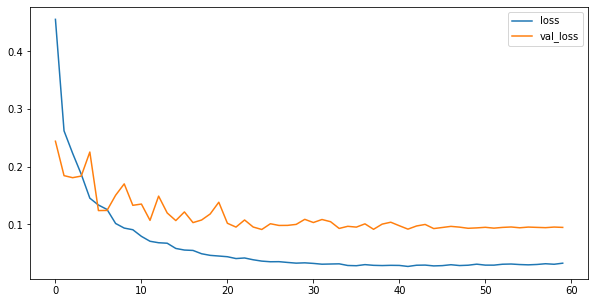

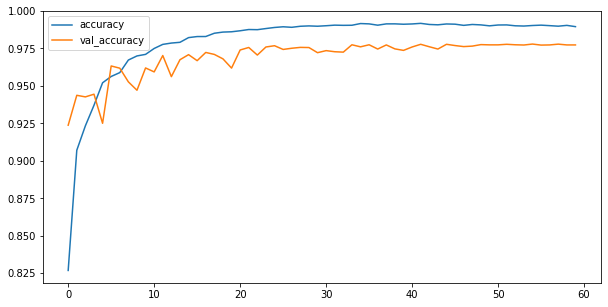

In [25]:
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 5)
data = pd.DataFrame(history.history)
metrics = ['loss', 'accuracy']

metrics_array = []

for metric in metrics:
    data[[f'{metric}',f'val_{metric}']].plot()

plot_location = f"/content/drive/MyDrive/CV_Research/TPU-Run-3/Plots/Final_Model_V3.jpg"
plt.savefig(plot_location)

csv_location = f"/content/drive/MyDrive/CV_Research/TPU-Run-3/CSV/Final_Model_V3.csv"

results_df = pd.DataFrame(history.history)
print(results_df)
results_df.to_csv(csv_location)

# Confusion matrix

In [26]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (18949,) [2 2 2 ... 2 2 2]
Predicted labels:  (18949,) [2 2 2 ... 2 2 2]


In [27]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
accuracy = accuracy_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
# display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

f1 score: 0.885, precision: 0.854, recall: 0.923


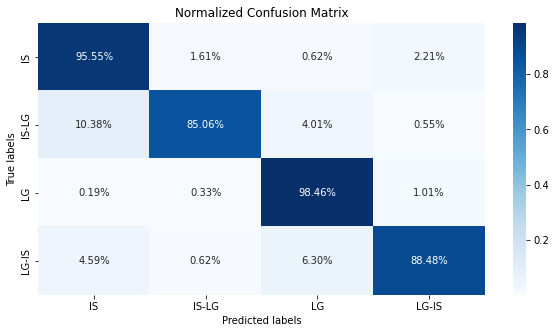

In [38]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cmat, annot=True, fmt='.2%', cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Normalized Confusion Matrix'); 
ax.xaxis.set_ticklabels(['IS', 'IS-LG', 'LG', 'LG-IS']); ax.yaxis.set_ticklabels(['IS', 'IS-LG', 'LG', 'LG-IS']);

plot_location = f"/content/drive/MyDrive/CV_Research/TPU-Run-3/CM_Plots/Final_Model_V3.jpg"
plt.savefig(plot_location)

# Final Test Predictions (Comment out until final model is generated)

In [39]:
cmdataset = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_TEST_IMAGES))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds, steps=TEST_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (37908,) [2 2 2 ... 0 0 0]
Predicted labels:  (37908,) [2 2 2 ... 0 3 0]


In [45]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
accuracy = accuracy_score(cm_correct_labels, cm_predictions)
# display_confusion_matrix(cmat, score, precision, recall)
print('accuracy: {:.3f}, f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(accuracy, score, precision, recall))

accuracy: 0.977, f1 score: 0.884, precision: 0.855, recall: 0.918


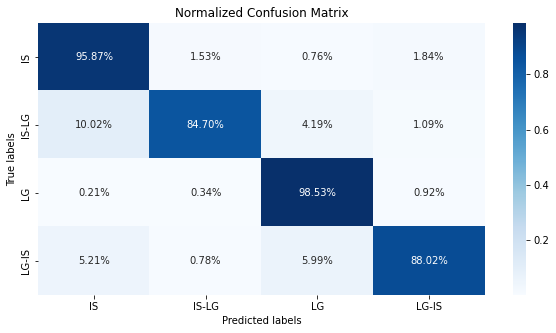

In [41]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cmat, annot=True, fmt='.2%', cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Normalized Confusion Matrix'); 
ax.xaxis.set_ticklabels(['IS', 'IS-LG', 'LG', 'LG-IS']); ax.yaxis.set_ticklabels(['IS', 'IS-LG', 'LG', 'LG-IS']);

# plot_location = f"/content/drive/MyDrive/CV_Research/TPU-Run-3/CM_Plots/Final_Test_Comparison_TPU_Plot_{current_time}_EP_{EPOCHS}_LR_{BASE_LR}_BS_{BATCH_SIZE}.jpg"
# plt.savefig(plot_location)

# Visual validation

In [32]:
# dataset = get_validation_dataset()
# dataset = dataset.unbatch().batch(20)
# batch = iter(dataset)

In [33]:
# # run this cell again for next set of images
# images, labels = next(batch)
# probabilities = model.predict(tf.cast(images, tf.float32))
# predictions = np.argmax(probabilities, axis=-1)
# display_batch_of_images((images, labels), predictions)